In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import math
import scipy.optimize as op

data = sio.loadmat('data/ex5data1.mat')
X = data['X']
y = data['y']
Xtest = data['Xtest']
ytest = data['ytest']
Xval = data['Xval']
yval = data['yval']

In [2]:
print('X.shape: ', X.shape)
print('y.shape: ', y.shape)
print('Xtest.shape: ', Xtest.shape)
print('ytest.shape: ', ytest.shape)
print('Xval.shape: ', Xval.shape)
print('yval.shape: ', yval.shape)

X.shape:  (12, 1)
y.shape:  (12, 1)
Xtest.shape:  (21, 1)
ytest.shape:  (21, 1)
Xval.shape:  (21, 1)
yval.shape:  (21, 1)


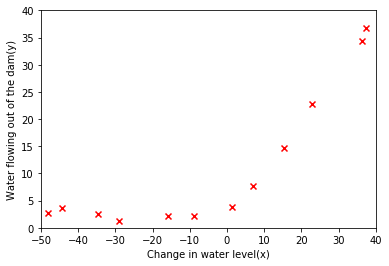

In [4]:
# 可视化训练集
plt.scatter(X, y, c='r', marker='x')
plt.axis([-50, 40, 0, 40])
plt.ylabel('Water flowing out of the dam(y)')
plt.xlabel('Change in water level(x)')
plt.show()

In [22]:
# 在X前加一列1
X = np.c_[np.ones(X.shape[0]), X]
Xval = np.c_[np.ones(Xval.shape[0]), Xval]

In [12]:
# 定义正则cost函数和正则gradient函数
def cost_regular(theta, X, y, ld):
    # theta (n, )   X (m, n)  y (m,1)
    m, n = X.shape
    theta = theta[:, None]
    difference = X.dot(theta) - y
    # without regular
    cost = 1.0/(2*m)*(difference.T.dot(difference))
    return cost + ld/(2.0*m)*(theta[1:].T.dot(theta[1:]))

def gradient_regular(theta, X, y, ld):
    # theta (n, )   X (m, n)  y (m,1)
    m, n = X.shape
    theta = theta[:, None]
    # without regular
    difference = X.dot(theta) - y
    gradient = 1.0/m*(X.T.dot(difference))
    # add regular
    gradient[1:] += ld/m*theta[1:]
    return gradient

init_theta = np.ones(2)
print(cost_regular(init_theta, X, y, 1))  # 输出应为303.993
print(gradient_regular(init_theta, X, y, 1))  # 输出应为[-15.30; 598.250]

[[303.99319222]]
[[-15.30301567]
 [598.25074417]]


In [21]:
# TrainNN
def train(init_theta, X, y, ld, cost_function, gradient_function):
    res = op.minimize(fun=cost_function, x0=init_theta, args=(X, y, ld), method='TNC', jac=gradient_function)
    return res['x']

[13.08790351  0.36777923]


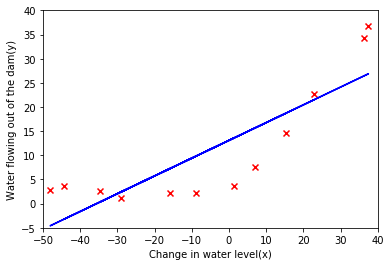

In [20]:
# for lambda=0 optimize the cost function, and virtualize
res_theta = train(np.zeros(2), X, y, 0, cost_regular, gradient_regular)
print(res_theta)
# 画出预测的线
plt.plot(X[:, 1], X.dot(res_theta), c='b')
# 画出训练集的点
plt.scatter(X[:, 1], y, c='r', marker='x')
plt.axis([-50, 40, -5, 40])
plt.ylabel('Water flowing out of the dam(y)')
plt.xlabel('Change in water level(x)')
plt.show()

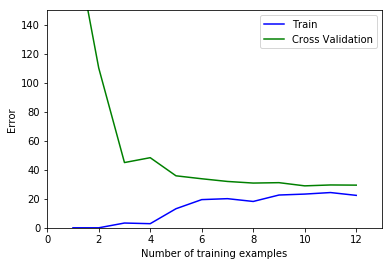

In [30]:
def learningCurve(x_train, y_train, x_val, y_val, ld):
    cost_without_regular = lambda theta, X, y : cost_regular(theta, X, y, 0)
    m, n = x_train.shape
    error_train = np.zeros(m)
    error_val = np.zeros(m)
    for i in range(m):
        theta = train(np.zeros(n), x_train[:i+1], y_train[:i+1], ld, cost_regular, gradient_regular)
        error_train[i] = cost_without_regular(theta, x_train[:i+1], y_train[:i+1])
        error_val[i] = cost_without_regular(theta, x_val, y_val)
    return error_train, error_val
    
error_train, error_val = learningCurve(X, y, Xval, yval, 0)
plt.plot(np.arange(X.shape[0])+1, error_train, c='b', label='Train')
plt.plot(np.arange(X.shape[0])+1, error_val, c='g', label='Cross Validation')
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.axis([0,13,0,150])
plt.legend(loc='best')

In [35]:
# 因为之前已经给X添加了一个全为1的列, 现在用x_表示训练集中的特征. xval_同理
x_ = X[:, 1:]
xval_ = Xval[:, 1:]

In [159]:
# 从上图中可以看出是欠拟合, 所以我们使用多项式来增加特征
# 该函数最终得到m*(p+1)的矩阵, 最高次为p, 同时添加了一列1; 该函数同时对所有特征进行了归一化.
# 返回矩阵, mu, simga
def get_polyfeature(x_, p):
    assert x_.ndim==2
    #assert p>1
    m = len(x_)
    # res = x_.copy()
    res = np.ones(m)
    for i in range(1, p+1):
        res = np.c_[res, x_**i]
    return res
def feature_normal(x_):
    mu, sigma = np.mean(x_[:, 1:], axis=0), np.std(x_[:, 1:], axis=0, ddof=1)
    res = x_.copy()
    res[:,1:] -= mu
    res[:,1:] /= sigma
    return res, mu, sigma

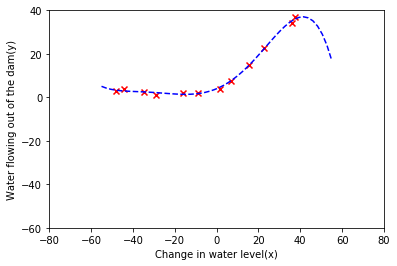

In [187]:
def plotFit(fit_theta,means,stds, k):
    n_points_to_plot = 50
    xvals = np.linspace(-55,55,n_points_to_plot)
    xmat = get_polyfeature(xvals[:, None], k)
    # feature normalization
    xmat[:,1:] = xmat[:,1:] - means
    xmat[:,1:] = xmat[:,1:] / stds
    plt.plot(xvals, xmat.dot(fit_theta),'b--')

k = 5
X8 =  get_polyfeature(x_, k)
X8,  mu8, sigma8 = feature_normal(X8)
res_theta = train(np.zeros(k+1), X8, y, 0, cost_regular, gradient_regular)
# 画出预测的线
plotFit(res_theta[:, None], mu8, sigma8, k)
# 画出训练集的点
plt.scatter(x_, y, c='r', marker='x')
plt.axis([-80, 80, -60, 40])
plt.ylabel('Water flowing out of the dam(y)')
plt.xlabel('Change in water level(x)')
plt.show()

In [180]:
def learningCurve_poly_lambda(x_train, y_train, x_val, y_val, poly=1, ld=0):
    cost_without_regular = lambda theta, X, y : cost_regular(theta, X, y, 0)
    X_train =  get_polyfeature(x_train, poly)
    X_val = get_polyfeature(x_val, poly)
    
    m, n = X_train.shape
    error_train = np.zeros(m)
    error_val = np.zeros(m)
    for i in range(1,m):
        # train set normalize
        xtrain_normal, mu_train, sigma_train = feature_normal(X_train[:i+1])
        theta = train(np.zeros(n), xtrain_normal[:i+1], y_train[:i+1], ld, cost_regular, gradient_regular)
        error_train[i] = cost_without_regular(theta, xtrain_normal[:i+1], y_train[:i+1])
        # normal val set
        xval_normal = X_val.copy()
        xval_normal[:, 1:] -= mu_train
        xval_normal[:, 1:] /= sigma_train
        error_val[i] = cost_without_regular(theta, xval_normal, y_val)
    return error_train, error_val

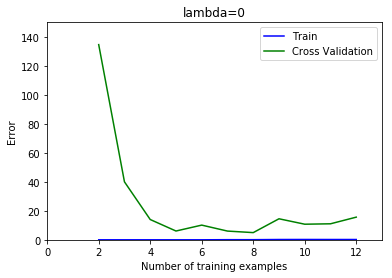

In [188]:
error_train, error_val = learningCurve_poly_lambda(x_, y, xval_, yval,5)
plt.plot(np.arange(X.shape[0]-1)+2, error_train[1:], c='b', label='Train')
plt.plot(np.arange(X.shape[0]-1)+2, error_val[1:], c='g', label='Cross Validation')
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.title('lambda=0')
plt.axis([0,13,0,150])
plt.legend(loc='best')

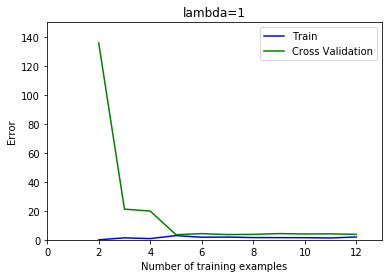

In [190]:
error_train, error_val = learningCurve_poly_lambda(x_, y, xval_, yval,5,1)
plt.plot(np.arange(X.shape[0]-1)+2, error_train[1:], c='b', label='Train')
plt.plot(np.arange(X.shape[0]-1)+2, error_val[1:], c='g', label='Cross Validation')
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.title('lambda=1')
plt.axis([0,13,0,150])
plt.legend(loc='best')

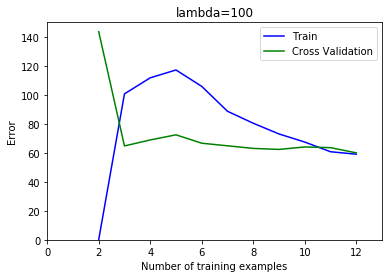

In [191]:
error_train, error_val = learningCurve_poly_lambda(x_, y, xval_, yval,5,100)
plt.plot(np.arange(X.shape[0]-1)+2, error_train[1:], c='b', label='Train')
plt.plot(np.arange(X.shape[0]-1)+2, error_val[1:], c='g', label='Cross Validation')
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.title('lambda=100')
plt.axis([0,13,0,150])
plt.legend(loc='best')

In [200]:
def get_error_byreg(x_train, y_train, x_val, y_val, poly = 1, ld=0):
    cost_without_regular = lambda theta, X, y : cost_regular(theta, X, y, 0)
    X_train =  get_polyfeature(x_train, poly)
    X_val = get_polyfeature(x_val, poly)
    
    m, n = X_train.shape
    xtrain_normal, mu_train, sigma_train = feature_normal(X_train)
    theta = train(np.zeros(n), xtrain_normal, y_train, ld, cost_regular, gradient_regular)
    error_train = cost_without_regular(theta, xtrain_normal, y_train)
    # normal val set
    xval_normal = X_val.copy()
    xval_normal[:, 1:] -= mu_train
    xval_normal[:, 1:] /= sigma_train
    error_val = cost_without_regular(theta, xval_normal, y_val)
    return error_train, error_val

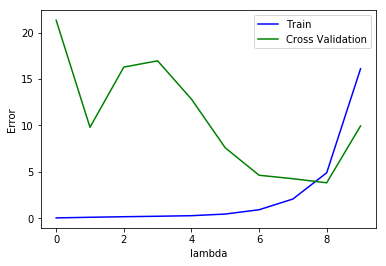

In [225]:
list_lambda = [0, 1e-3, 3e-3, 1e-2, 3e-2, 0.1, 0.3, 1, 3, 10]
error_train = []
error_val = []
for i in [0, 1e-3, 3e-3, 1e-2, 3e-2, 0.1, 0.3, 1, 3, 10]:
    error_train_, error_val_ = get_error_byreg(x_, y, xval_, yval, 8,i)
    error_train.append(error_train_[0][0])
    error_val.append(error_val_[0][0])
    
plt.plot(np.arange(len(list_lambda)), error_train, c='b', label='Train')
plt.plot(np.arange(len(list_lambda)), error_val, c='g', label='Cross Validation')
plt.xlabel('lambda')
plt.ylabel('Error')
plt.legend(loc='best')